In [1]:
# !/usr/bin/python3 -m pip install --upgrade pip
# !pip install opencv-python
# !apt update
# !apt install ffmpeg libsm6 libxext6  -y
# !pip install tensorflow-addons
# !pip install tqdm

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'
TMPDIR = '/root/Internship-Valeo/Project/tmp'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives

In [7]:
config = {
            'primitives': 'all',
            'truncate': {},
            'validation_size': -1,
            'test_size': -1,
            'on-the-fly': False,
            'cache_in_memory': False,
            'suffix': None,
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'generation': {
                'split_sizes': {'training': 10000, 'validation': 200, 'test': 500},
                'image_size': [960, 1280],
                'random_seed': 0,
                'params': {
                    'generate_background': {
                        'min_kernel_size': 150, 'max_kernel_size': 500,
                        'min_rad_ratio': 0.02, 'max_rad_ratio': 0.031},
                    'draw_stripes': {'transform_params': (0.1, 0.1)},
                    'draw_multiple_polygons': {'kernel_boundaries': (50, 100)}
                },
            },
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': False,
                    'primitives': 'all',
                    'params': {},
                    'random_order': True,
                },
                'homographic': {
                    'enable': False,
                    'params': {},
                    'valid_border_margin': 0,
                },
            }
    }
drawing_primitives = [
            'draw_lines',
            'draw_polygon',
            'draw_multiple_polygons',
            'draw_ellipses',
            'draw_star',
            'draw_checkerboard',
            'draw_stripes',
            'draw_cube',
            'gaussian_noise'
    ]

In [8]:
def dump_primitive_data(primitive, tar_path, config):
    temp_dir = Path(TMPDIR, primitive)

    synthetic_dataset.set_random_state(np.random.RandomState(
                config['generation']['random_seed']))
    for split, size in config['generation']['split_sizes'].items():
        im_dir, pts_dir = [Path(temp_dir, i, split) for i in ['images', 'points']]
        im_dir.mkdir(parents=True, exist_ok=True)
        pts_dir.mkdir(parents=True, exist_ok=True)

        for i in tqdm(range(size), desc=split, leave=False):
            image = synthetic_dataset.generate_background(
                        config['generation']['image_size'],
                        config['generation']['params']['generate_background'])
            points = np.array(getattr(synthetic_dataset, primitive)(
                        image, config['generation']['params'].get(primitive, {})))
            points = np.flip(points, 1)  # reverse convention with opencv

            b = config['preprocessing']['blur_size']
            image = cv2.GaussianBlur(image, (b, b), 0)
            points = (points * np.array(config['preprocessing']['resize'], np.float)
                          / np.array(config['generation']['image_size'], np.float))
            image = cv2.resize(image, tuple(config['preprocessing']['resize'][::-1]),
                                   interpolation=cv2.INTER_LINEAR)

            cv2.imwrite(str(Path(im_dir, '{}.png'.format(i))), image)
            np.save(Path(pts_dir, '{}.npy'.format(i)), points)

    # Pack into a tar file
    tar = tarfile.open(tar_path, mode='w:gz')
    tar.add(temp_dir, arcname=primitive)
    tar.close()
    shutil.rmtree(temp_dir)

In [9]:
primitives = parse_primitives(config['primitives'], drawing_primitives)
basepath = Path(
                DATA_PATH, 'synthetic_shapes' +
                ('_{}'.format(config['suffix']) if config['suffix'] is not None else ''))
basepath.mkdir(parents=True, exist_ok=True)

splits = {s: {'images': [], 'points': []}
                  for s in ['training', 'validation', 'test']}

In [10]:
# for primitive in primitives:
#     tar_path = Path(basepath, '{}.tar.gz'.format(primitive))
#     if not tar_path.exists():
#         dump_primitive_data(primitive, tar_path, config)

In [11]:
for primitive in primitives:
    # Untar locally
#     tar_path = Path(basepath, '{}.tar.gz'.format(primitive))
#     tar = tarfile.open(tar_path)
    temp_dir = Path(TMPDIR)
#     tar.extractall(path=temp_dir)
#     tar.close()
    # Gather filenames in all splits, optionally truncate
    truncate = config['truncate'].get(primitive, 1)
    path = Path(temp_dir, primitive)
    for s in splits:
        e = [str(p) for p in Path(path, 'images', s).iterdir()]
        f = [p.replace('images', 'points') for p in e]
        f = [p.replace('.png', '.npy') for p in f]
        splits[s]['images'].extend(e[:int(truncate*len(e))])
        splits[s]['points'].extend(f[:int(truncate*len(f))])

In [12]:
# Shuffle
for s in splits:
    perm = np.random.RandomState(0).permutation(len(splits[s]['images']))
    for obj in ['images', 'points']:
        splits[s][obj] = np.array(splits[s][obj])[perm].tolist()

In [13]:
len(splits['training']['images']), len(splits['test']['images']), len(splits['validation']['images'])

(90000, 4500, 1800)

In [14]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [15]:
class SyntheticShapes(keras.utils.Sequence):
    def __init__(self, image_files, point_files, batch_size):
        self.__image_files, self.__point_files = image_files, point_files
        self.__batch_size = batch_size
    
    def __getitem__(self, index):
        images = []
        points_maps = []
        batch_img_files = self.__image_files[index * self.__batch_size:(index + 1) * self.__batch_size]
        batch_point_files = self.__point_files[index * self.__batch_size:(index + 1) * self.__batch_size]
        for img_file, point_file, itr in zip(batch_img_files, batch_point_files, range(self.__batch_size)):
            image = cv2.imread(img_file, 0)
            image = image / 255.0
            points = _read_points(point_file)
            points_map = np.zeros((image.shape[0],image.shape[1]))
            points = np.round(points).astype(int)
            for i in range(len(points)):
                # skip the points whose co-ordinates lie outside image shape
                if not(points[i][0] >= image.shape[0] or points[i][1] >= image.shape[1]):
                    points_map[points[i][0],points[i][1]] = 1
            images.append(image)
            points_maps.append(points_map)
            

        images = np.array(images)
        points_maps = np.expand_dims(points_maps, axis = 3)
        return images, points_maps
    
    def __len__(self):
        return int(np.ceil(len(self.__image_files) / float(self.__batch_size)))

In [16]:
#         data = data.map(lambda image, kp: {'image': image, 'keypoints': kp})
#         data = data.map(pipeline.add_dummy_valid_mask)

#         # Apply augmentation
#         if split_name == 'training' or config['add_augmentation_to_test_set']:
#             if config['augmentation']['photometric']['enable']:
#                 data = data.map_parallel(lambda d: pipeline.photometric_augmentation(
#                     d, **config['augmentation']['photometric']))
#             if config['augmentation']['homographic']['enable']:
#                 data = data.map_parallel(lambda d: pipeline.homographic_augmentation(
#                     d, **config['augmentation']['homographic']))

#         # Convert the point coordinates to a dense keypoint map
#         data = data.map_parallel(pipeline.add_keypoint_map)

In [17]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
#             'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0
    }

In [18]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [19]:
def shared_encoder(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return conv8

In [20]:
def detector_head(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel


    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

#     prob = tf.nn.softmax(x, axis=cindex)
#     # Strip the extra “no interest point” dustbin
#     prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
#     prob = tf.nn.depth_to_space(
#               prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     prob = tf.squeeze(prob, axis=cindex)
#     return {'logits': x, 'prob': prob}
    return x

In [21]:
def net(input_shape = (240, 320, 1)):
    inputs = Input(shape = input_shape)
    encoder_output = shared_encoder(inputs, model_config=model_config)
    output = detector_head(encoder_output, model_config=model_config)
    model = keras.models.Model(inputs = inputs , outputs = output)
    return model

In [22]:
model = net(input_shape = (240, 320, 1))

In [23]:
# model.summary()

In [24]:
def detector_loss(keypoint_map, logits, model_config, valid_mask=None):
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
#     valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
#     valid_mask = tf.cast(valid_mask, tf.float32)
#     valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
#     valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
 
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    return loss

def wrapper_fn(model_config):
    def loss_fn(y_true, y_pred):
        return detector_loss(y_true, y_pred, model_config=model_config)
#                              valid_mask=inputs['valid_mask'])
    return loss_fn

In [25]:
def model_metrics(y_true, y_pred):
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    prob = tf.nn.softmax(y_pred, axis=cindex)
    y_true = tf.nn.space_to_depth(y_true, model_config['grid_size'])
    y_true = tf.cast(y_true, tf.float32)
    # Strip the extra “no interest point” dustbin
    prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]

    precision = tf.math.reduce_sum(prob * y_true) /tf.math.reduce_sum(prob)
    recall = tf.math.reduce_sum(prob * y_true) / tf.math.reduce_sum(y_true)
#     return {'precision': precision, 'recall': recall}
    return precision

In [26]:
model_loss = wrapper_fn(model_config=model_config)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
              loss = model_loss, metrics = [model_metrics])

In [27]:
batch_size = 64

epochs = 25

train_gen = SyntheticShapes(splits['training']['images'], splits['training']['points'], batch_size = batch_size)
val_gen = SyntheticShapes(splits['validation']['images'], splits['validation']['points'], batch_size = batch_size)

train_steps =  len(splits['training']['images'])/batch_size

history = model.fit(train_gen , validation_data = val_gen, steps_per_epoch = train_steps, epochs=epochs)

Epoch 1/25
1406/1406 [==============================] - 626s 440ms/step - loss: 2.6814 - model_metrics: 6.9004e-04 - val_loss: 1.3547 - val_model_metrics: 6.8953e-04
Epoch 2/25
1406/1406 [==============================] - 620s 441ms/step - loss: 0.7891 - model_metrics: 0.0020 - val_loss: 0.2795 - val_model_metrics: 0.0019
Epoch 3/25
1406/1406 [==============================] - 618s 439ms/step - loss: 0.2337 - model_metrics: 0.0075 - val_loss: 0.2071 - val_model_metrics: 0.0098
Epoch 4/25
1406/1406 [==============================] - 622s 442ms/step - loss: 0.1019 - model_metrics: 0.0189 - val_loss: 0.0661 - val_model_metrics: 0.0190
Epoch 5/25
1406/1406 [==============================] - 616s 438ms/step - loss: 0.0537 - model_metrics: 0.0456 - val_loss: 0.0408 - val_model_metrics: 0.0585
Epoch 6/25
1406/1406 [==============================] - 614s 436ms/step - loss: 0.0307 - model_metrics: 0.1063 - val_loss: 0.0255 - val_model_metrics: 0.1295
Epoch 7/25
1406/1406 [======================

In [45]:
model.save('checkpoint')

INFO:tensorflow:Assets written to: checkpoint/assets


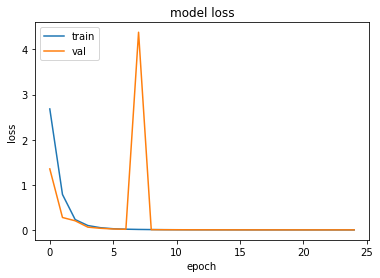

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

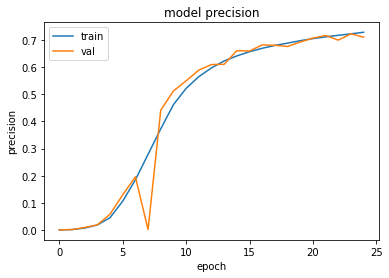

In [44]:
plt.plot(history.history['model_metrics'])
plt.plot(history.history['val_model_metrics'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
x, y = train_gen.__getitem__(0)

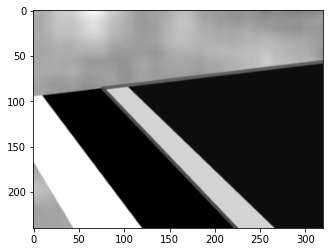

In [47]:
plt.imshow(x[0], cmap = 'gray')

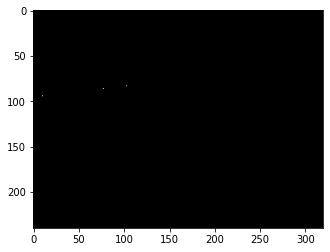

In [48]:
plt.imshow(y[0],cmap = 'gray')

In [31]:
test_gen = SyntheticShapes(splits['test']['images'], splits['test']['points'], batch_size = batch_size)

In [32]:
x, y = test_gen.__getitem__(1)

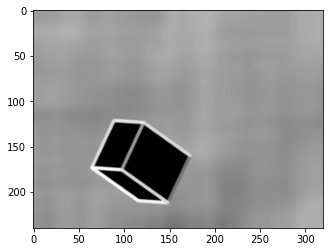

In [33]:
plt.imshow(x[1], cmap = 'gray')

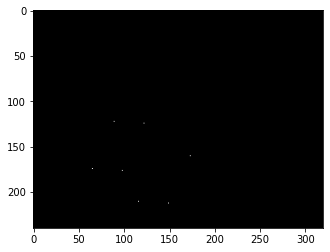

In [34]:
plt.imshow(y[1], cmap='gray')

In [49]:
result = model.predict(x)

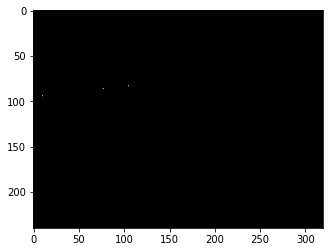

In [50]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel
labels = tf.argmax(result, axis =cindex)
one_hot = np.zeros_like(result)

for unique_value in range(result.shape[cindex]):
    one_hot[:,:,:,unique_value][labels == unique_value] = 1
    
prob = one_hot
# Strip the extra “no interest point” dustbin
prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
prob = tf.nn.depth_to_space(
              prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
prob = tf.squeeze(prob, axis=cindex)

plt.imshow((prob)[0], cmap = 'gray')

In [37]:
model_metrics(y, result)

<tf.Tensor: shape=(), dtype=float32, numpy=0.70454735>